In [25]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
import torch.optim as optim
import time

import dpf
import dpf_toy

def to_torch(x):
    return torch.from_numpy(x.astype(np.float32)).to(device)
def to_numpy(x):
    return x.detach().cpu().numpy()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
### Some helpers for generating data
###

observer = dpf_toy.BeaconObserver()
observer.add_beacon((5, 3), 0.2)
observer.add_beacon((22, 8), 0.5)
observer.add_beacon((12, -10), 0.5)

# Simulation
def simulate_trajectory(timesteps=100):
    dynamics = dpf_toy.RobotDynamicsModel()

    # Generate states, control inputs
    states = [np.array([0., 0., 0.])]
    
    # First control input is unuseful -- inject NaNs to make sure they're never used :)
    controls = [np.array([np.nan, np.nan])]
    for _ in range(timesteps):
        control = torch.from_numpy(np.random.uniform(
            low=[0, -0.1], high=[0.4, 0.1], size=(2,)).astype(np.float32))
        new_state = dynamics.forward(
            torch.from_numpy(states[-1][np.newaxis, np.newaxis, :].astype(np.float32)), control[np.newaxis,:], noisy=True)

        states.append(new_state[0,0].numpy())
        controls.append(control.numpy())

    # Remove initial state
    states = states

    # Generate observations from ground-truth states
    observations = observer.forward(states)

    return states, observations, controls

# Dead-reckoning
def dead_reckon(controls, initial_state=np.array([0., 0., 0.])):
    dynamics = dpf_toy.RobotDynamicsModel()

    states = [initial_state]
    for control in controls:
        new_state = dynamics.forward(
            torch.from_numpy(states[-1][np.newaxis, :].astype(np.float32)), control, noisy=False)
        states.append(new_state[0].numpy())
    
    # Remove initial state and return
    return states

# Visualization helper
def plot_trajectories(*states_list, **states_dict):
    import itertools
    plt.figure()
    for label, states in itertools.chain(states_dict.items(), enumerate(states_list)):
        if label == "particles":
            # Format for particles should be states, log_weights
            assert len(states) == 2
            states, log_weights = states
            weights = np.exp(log_weights)
            weights /= np.max(weights)
            
            rgba = np.zeros((len(weights),4))
            rgba[:,3] = weights * 0.9 + 0.1

            x = np.asarray(states).T[0]
            y = np.asarray(states).T[1]
            plt.scatter(x, y, label=label, c=rgba)
        else:
            x = np.asarray(states).T[0]
            y = np.asarray(states).T[1]
            plt.scatter(x, y, label=label)

        
    plt.legend()
    plt.show()


In [27]:
## Generate some training data
#
training_trajectories = []
for _ in range(100):
    # States, observations, controls
    s, o, u = simulate_trajectory(80)
    training_trajectories.append((np.asarray(s), np.asarray(o), np.asarray(u)))

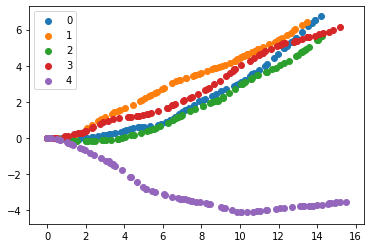

In [28]:
plot_trajectories(*[t[0] for t in training_trajectories[:5]])


In [29]:
# Initialize particle filter network
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print("Using device:", device)

try:
    del pfnet
    torch.cuda.empty_cache()
    print("Deleted old model!")
except:
    pass

torch.autograd.set_detect_anomaly(True)
dynamics = dpf_toy.DeepRobotDynamicsModel()
measurements = dpf_toy.DeepBeaconMeasurementModel()
# measurements = dpf_toy.BeaconMeasurementModel(observer)
pfnet = dpf.ParticleFilterNetwork(dynamics, measurements, 1.0).to(device)

Using device: cpu
Deleted old model!


In [30]:
trainset = dpf.ParticleFilterDataset(
    training_trajectories[0:1],
    subsequence_length=2,
    particle_count=100,
    particle_variances = [3, 3, 0.3]
)
trainset_loader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True, num_workers=1)

In [31]:
print("test")

test


In [32]:
# Define optimizer
optimizer = optim.Adam(pfnet.parameters())
def train(learning_rate=1e-5, log=True):
    # Set learning rate
    # print("Setting learning rate to", learning_rate)
    for g in optimizer.param_groups:
        g['lr'] = learning_rate

    # Train for 1 epoch
    for batch_idx, batch in enumerate(trainset_loader):
        # Transfer to GPU and pull out batch data
        batch_gpu = [x.to(device) for x in batch]
        batch_particles, batch_states, batch_obs, batch_controls = batch_gpu

        # N = batch size, M = particle count
        N, timesteps, obs_dim = batch_obs.shape
        N, timesteps, control_dim = batch_controls.shape
        N, timesteps, state_dim = batch_states.shape
        N, M, state_dim = batch_particles.shape
        assert batch_obs.shape == (N, timesteps, obs_dim)
        assert batch_controls.shape == (N, timesteps, control_dim)

        # Give all particle equal weights
        particles = batch_particles
        log_weights = torch.ones((N, M), device=device) * (-np.log(M))

        for t in range(1, timesteps):
            prev_particles = particles
            prev_log_weights = log_weights

            _, new_particles, new_log_weights = pfnet.forward(
                prev_particles,
                prev_log_weights,
                batch_obs[:,t - 1,:],
                batch_controls[:,t,:],
                resample=False
            )
            
            loss = dpf.gmm_loss(
                particles_states=new_particles,
                log_weights=new_log_weights,
                true_states=batch_states[:, t, :],
                gmm_variances=np.array([0.2, 0.2, 0.1])
            )

            
            optimizer.zero_grad()
            loss.backward(retain_graph=False)
            optimizer.step()
            assert loss.shape == ()

            particles = new_particles.detach()
            log_weights = new_log_weights.detach()

    if log:
        max_belief = torch.max(torch.exp(new_log_weights))
        print(to_numpy(loss), "\t", to_numpy(new_log_weights))


In [34]:
for i in range(1000):
    train(1e-3, log=(i%10 == 0))

3.0184913 	 [[-4.420812  -5.133828  -4.212543  -4.4894323 -5.023205  -4.4354086
  -4.2929373 -4.474739  -5.067316  -4.4958234 -4.7552695 -5.28082
  -5.183605  -4.417278  -4.971366  -4.1880536 -5.0606194 -4.5012913
  -4.8891964 -5.291395  -4.5703278 -4.361141  -4.6571236 -5.176916
  -4.5362864 -4.099896  -5.518152  -4.6444693 -4.958338  -4.727071
  -4.9597445 -4.860421  -4.6312866 -4.3492146 -4.5387926 -4.524761
  -4.252354  -4.243268  -5.0056353 -5.0088377 -5.1959295 -4.719964
  -4.6411567 -4.496996  -4.755602  -4.614711  -4.2112255 -4.1358633
  -5.070506  -4.477766  -4.459874  -4.535159  -4.8996677 -4.5820284
  -4.8922663 -4.5024424 -4.9744644 -4.859274  -4.348325  -5.125683
  -4.6694345 -5.2772474 -4.743801  -4.182913  -5.0178776 -4.82948
  -4.893218  -4.266913  -4.3954167 -4.270255  -4.4624257 -4.7562084
  -4.6980476 -4.288563  -4.692972  -4.6767273 -4.4597983 -4.245244
  -4.4297657 -4.2407913 -4.4059052 -4.61597   -4.6946096 -4.49018
  -4.9317026 -4.2258463 -4.4604883 -4.3122644 -4

2.8233643 	 [[-4.5306664 -4.7107496 -4.831192  -4.4824905 -4.6222014 -4.6508374
  -4.5150824 -4.5845146 -4.5880146 -4.8481116 -4.7561245 -4.484235
  -4.6972065 -4.5287886 -4.9254656 -4.6234846 -4.5502243 -4.558537
  -4.4908123 -4.6185474 -4.495368  -4.4850874 -4.5643153 -4.478837
  -4.6744432 -4.5173397 -4.6286435 -4.669154  -4.59361   -4.565449
  -4.6062813 -4.631264  -4.570408  -4.635565  -4.810591  -4.6646857
  -4.579898  -4.6527567 -4.598812  -4.539337  -4.609321  -4.723466
  -4.5997577 -4.523308  -4.5078707 -4.8841743 -4.693617  -4.4884777
  -5.0367484 -4.5253854 -4.6244926 -4.564295  -4.5405874 -4.6514597
  -4.6158752 -4.4926386 -4.5647154 -4.7050786 -4.6061735 -4.5469904
  -4.6723022 -4.61487   -4.61172   -4.5542464 -4.5060844 -4.5659876
  -4.6243706 -4.911832  -4.4978037 -4.53794   -4.6169834 -4.6196036
  -4.4867635 -4.486988  -4.5008698 -4.496894  -4.831635  -4.7267075
  -4.8582487 -4.52736   -4.8346214 -4.53238   -4.514349  -4.4980893
  -4.497695  -4.7079616 -4.48314   -4.970

2.2835248 	 [[-4.226611  -4.3045254 -3.8909109 -4.361607  -4.1864862 -6.611273
  -4.7013216 -6.8093557 -4.624487  -4.462697  -4.6162167 -4.5922465
  -4.168131  -3.9392004 -3.942466  -5.169181  -4.795287  -4.4019747
  -5.4410915 -3.9448793 -5.445013  -4.412547  -5.6192503 -4.487897
  -4.384323  -4.228308  -6.156245  -5.259198  -4.910283  -5.3691626
  -4.6167655 -3.8943624 -4.5250034 -5.0419827 -3.8988998 -4.932767
  -4.893992  -4.051228  -4.0758348 -5.343856  -4.341209  -4.201767
  -6.2575464 -5.347066  -4.320578  -4.4509287 -4.569026  -5.017701
  -6.0533676 -5.328622  -6.0611334 -5.723552  -5.825221  -5.1376514
  -5.184491  -4.0370617 -4.7387547 -5.8146544 -6.340806  -5.314925
  -6.2918024 -4.655202  -6.021785  -6.1382303 -4.8943844 -4.056258
  -4.4005594 -4.239794  -4.0719805 -4.066397  -4.962791  -6.215766
  -6.475549  -4.6003556 -6.2223244 -4.6522307 -4.1539125 -4.7879105
  -4.2365885 -4.3495026 -4.012045  -3.885416  -7.234021  -4.71342
  -6.203491  -4.6604548 -3.878321  -3.8986654 

2.2075667 	 [[-4.4405084 -4.760295  -4.539201  -4.295919  -4.7680006 -5.148407
  -4.5516415 -4.294753  -4.3555365 -4.330131  -4.4278383 -4.758048
  -4.7252216 -4.3317847 -4.3832645 -4.691259  -5.13591   -4.605008
  -5.0899544 -4.598792  -4.8710833 -4.2548923 -5.0999575 -4.604643
  -4.765721  -5.0559597 -5.746289  -4.634841  -4.873864  -4.3464174
  -4.6292114 -4.5681334 -4.397643  -4.9882474 -4.7668514 -4.4848766
  -4.445218  -4.683165  -5.195944  -4.991118  -4.500637  -4.3085475
  -4.321761  -4.4548936 -4.347499  -5.9627075 -4.591792  -5.312722
  -5.9319887 -5.307949  -4.732813  -4.974725  -4.4010553 -4.466218
  -4.2171335 -5.534667  -5.195713  -4.234724  -4.5862255 -4.283969
  -5.083392  -4.5144796 -4.3218184 -4.334927  -4.3284864 -4.559611
  -5.0152903 -4.703124  -4.526174  -5.009207  -5.054467  -4.4087944
  -4.291222  -6.227914  -4.4381514 -4.3783054 -4.634681  -5.248411
  -4.2511587 -4.2392344 -4.7574396 -4.2927513 -4.4824896 -4.502945
  -4.463503  -4.259385  -4.8123126 -4.307064  

1.5025616 	 [[ -4.29773    -5.804724   -5.1425314  -5.681552   -4.852765   -4.7135863
   -3.9342442  -3.8821151  -4.400817   -4.618514   -4.6525397  -4.7571573
   -4.521936   -4.8805504  -4.8666463  -4.0703883  -4.990446   -5.1929855
   -5.7299848  -4.1793776  -6.168912   -4.3997154  -4.106902   -3.7328684
   -4.2097416  -4.5428224  -4.7807274  -4.753807   -5.38951    -6.073721
   -4.9900775  -4.140582   -4.298277   -3.8840268  -3.9572034  -4.786047
   -4.007987   -5.605116   -4.5014954  -4.227935   -4.1539116  -4.58578
   -6.2182035  -4.627005   -4.5625277  -4.516737   -3.7498894  -5.801613
   -6.2453766  -4.9073324  -4.3259773  -5.698949   -5.613082   -4.492595
   -4.4571486  -4.807764   -6.946891   -4.75504    -4.2376575  -3.9700155
   -4.5238028  -3.9029996  -5.34726    -4.500766   -3.7939205  -5.3416815
   -4.606819   -6.0689144  -4.3106217  -5.276039   -4.62303    -3.7597191
   -4.8755217  -4.570386   -4.6621537  -5.207267   -4.5419216  -4.47369
   -5.913521   -5.8073983  -4.3092

1.3414761 	 [[ -6.069438   -6.974867  -10.14501    -4.045027   -4.2632675  -4.8180614
   -5.521638   -5.9895535  -4.3035784  -6.3536196  -4.2627277  -5.839778
   -5.451294  -11.235219   -4.474063   -6.6414766  -4.607852   -8.368664
   -3.5566278  -9.776225   -4.229276  -10.322015   -4.472208   -6.230892
   -3.1340637  -3.277523   -4.8985376  -3.427287   -6.850296   -4.625396
   -4.620332   -5.5128956  -3.9326212  -7.258127  -10.209006   -6.0789256
   -5.133643   -4.9985085  -9.365004   -5.041751   -6.1344895  -6.411208
   -3.52429    -4.6572313  -6.977769   -4.3273597  -8.676505   -3.6355934
   -9.384821   -9.585318   -3.8317056  -3.6222606 -10.802739   -4.055309
   -8.849057   -6.0791054  -4.7631273  -9.34567    -4.0366697  -3.293064
   -3.6970415  -4.2128563  -4.816799   -6.587433   -6.991436   -7.4372854
   -3.6610203  -4.7205896  -3.51477    -6.1228914  -4.2568874  -9.594654
   -4.3405824  -4.4815817  -4.3272867  -3.529447   -4.7301083  -5.856451
   -5.428125   -6.181137   -3.50068

16.755857 	 [[ -3.8172565  -6.064088   -8.388655   -8.740076   -8.439311   -8.552159
   -9.209906   -8.40579    -6.070853   -5.8787236  -4.5648613  -4.8496275
   -3.9844875  -4.785773   -7.397537   -3.8923826 -10.031742   -3.7070255
   -4.1464405  -4.379697   -4.698949   -5.5931597  -3.7481327  -4.076408
  -11.661699   -3.6206222 -10.086672   -3.8496099  -4.5165358  -5.476037
   -3.9269295  -4.0747933  -3.5060525  -8.336098   -3.6611214  -6.215307
   -3.853939   -5.0311556  -3.5276685  -5.774935   -7.7855153  -4.2914715
   -3.73633    -6.8454337  -5.489878   -5.6334877  -5.815304   -8.9902
   -3.6935163  -3.6302257  -3.6108236  -4.8638763  -3.9267135  -8.008625
   -4.0786295  -4.48654    -4.267615   -7.063287   -5.9346924  -4.3015895
   -4.5810485  -8.129192   -4.1866336 -13.373581   -4.600195   -3.7673078
   -3.6755023  -5.6324615  -6.132181   -6.102504   -4.889759   -9.640409
   -5.156884   -4.364578   -5.7435255  -4.383743   -3.9066644  -8.375969
   -4.1906667  -3.6823835  -8.344627

1.055374 	 [[ -3.4353647  -8.514013   -3.8886452  -4.0420456  -4.1369643  -6.164713
  -11.852804   -7.7816143  -7.2023063  -3.5969443  -5.3443775 -12.375191
   -8.228603   -8.766107   -6.898278  -12.882229   -5.771295   -3.6866293
   -3.5022726  -7.1881123  -3.7853932  -7.5569     -6.11631    -6.5338383
   -4.3902707  -6.7835097  -3.9842567  -7.108829   -8.053267   -7.7048836
  -12.893629   -3.8425002  -8.129513   -3.5160294  -5.3017025  -3.7732787
   -3.5774326  -4.831387   -7.498179   -5.5618544  -5.3507533  -3.9514751
   -6.0461473  -7.1979847  -3.979136  -14.770599   -3.5727482 -11.381859
   -6.0398912  -8.314898   -3.4599037  -4.3928175  -9.7059765 -11.552933
   -5.774062   -4.1338606  -8.516151   -3.6580968  -3.4142652  -6.2057657
   -7.2311893 -11.360346   -5.3058233  -3.3214116  -4.7982006  -6.00737
   -3.6162353  -5.255089   -4.097676  -14.83535   -11.973377   -5.596957
   -6.2780704  -8.103307   -6.521146   -3.9084039  -5.1371636  -8.092669
  -10.681969   -3.7277255  -3.65945

0.68769115 	 [[ -3.5469148  -8.042389  -13.822491   -7.457531   -5.81653    -4.6571903
   -3.9194095  -5.0181427  -5.9275064  -7.7313404 -13.79004    -3.4051921
   -5.5226774 -10.94795    -3.5641272  -4.9295626 -10.898529   -3.4365175
   -6.9457684  -4.367922   -7.406043   -3.664109   -9.453542  -11.4692
   -3.4618418  -3.4501684  -3.4916313 -13.182367   -5.0723715  -3.533077
   -6.047598   -4.5871534  -9.953093  -11.206929   -3.7388556 -14.691615
   -3.5375535  -4.9680223  -4.218831   -4.4905586 -12.913271  -10.84052
  -12.100594   -5.5082264  -4.5331945 -14.571815   -6.1774817  -3.6734087
  -11.543904   -3.7971737 -11.800635   -5.2359066  -4.27938   -10.586597
  -11.227501   -3.8732197  -6.275502   -5.425434   -4.3254786  -7.377717
   -5.1069994  -6.059367   -7.837944   -4.26985    -6.8476715 -11.385427
   -4.1170826  -4.430356   -6.809805   -5.073781  -14.119735  -14.696692
   -4.919243   -3.6477258 -10.870807   -3.2496316  -3.964908   -5.1224756
   -4.5667276 -16.913445   -3.341735

0.16635422 	 [[ -7.164858   -4.7197857  -8.492138  -19.59938   -12.232191   -8.351681
   -6.17505    -8.778122   -3.9949553  -4.6714106  -6.53362   -13.056778
   -9.909992   -8.017113   -4.0497675  -9.552386   -6.0919027  -2.5570414
   -6.732188  -19.684404  -15.103365  -13.151403   -2.782213   -7.7812185
  -10.944512   -2.5456278 -18.680037   -5.340522  -13.154984  -16.654942
   -5.486352  -15.675808   -2.964516   -4.0854797  -3.1616185 -11.491162
  -12.06018    -5.095648   -7.0202923  -4.614765   -7.7142267  -5.1923933
   -5.3301525  -8.708368   -6.0380144 -16.28273   -19.072174   -6.814621
  -12.514361   -3.2223814  -3.9315975  -2.3186915 -10.526007  -18.088314
  -17.660656   -8.307496  -13.399302  -16.820992  -17.139175   -5.7729816
   -8.744871   -4.377939  -13.684589  -14.431784  -10.959249  -22.265491
  -16.046     -15.459507   -3.963484   -2.786885  -22.48237    -3.9240382
   -6.193179  -13.434381  -14.115419   -4.1694126 -11.818203   -5.0952835
   -9.821404   -9.091969  -11.25

1.0659285 	 [[-15.197029  -14.416994  -16.00091   -13.993786   -5.468164  -11.744896
   -6.576747   -6.8951693  -7.93341    -4.0416527  -2.4857755 -10.910337
  -10.707348  -20.654245   -5.995361  -11.963525   -7.111575   -9.788684
   -2.3406215 -19.244272  -15.513344   -4.077647   -1.3588157 -15.690195
  -18.919527  -12.36347   -10.923464   -8.825806  -24.12835    -2.8456492
  -16.800951   -9.024887  -10.510823   -7.328182  -22.736332  -14.117588
  -16.994377  -24.105867   -8.735643  -24.856298  -10.028152  -10.777777
  -13.705089  -25.126059   -7.288843   -5.3983116  -9.923616  -14.981255
   -5.308343  -15.593826   -7.5864754  -5.618974   -6.9670234  -8.096693
   -9.829193   -7.5677176  -9.955061   -5.762255  -12.576748  -12.484739
  -19.316418  -11.973074   -5.3816595  -4.5084844  -7.033196   -4.7252665
  -12.169161   -3.775271   -3.022159  -12.175308  -26.89177   -15.390871
  -22.697792  -16.297892   -8.528482   -8.363543  -14.030397   -4.26805
  -16.1763     -6.0004277  -5.9838357 

-0.2211765 	 [[ -4.9921017  -2.2808526  -5.164036  -13.690057   -4.0517445  -3.1705978
   -8.372496   -1.8855503 -10.592393   -7.1405134 -10.265476   -8.946851
  -10.119732   -5.285228   -3.7484424 -12.899787   -6.4941134 -26.476532
  -20.661295  -20.429737   -4.886479   -5.144414  -13.962901   -4.6993055
   -4.5922346  -7.2893486  -5.9341383  -3.4736025 -25.421093  -17.064787
   -3.036392   -8.625018   -6.694979   -2.551284   -3.0724118  -9.968055
  -19.289644   -5.0299377 -19.23034    -3.3276289 -18.88921   -10.537342
   -7.3231792 -10.770565  -16.844791  -13.205105   -3.0604455  -7.7178974
   -6.139243   -4.699174  -10.516314   -4.163637  -15.401671  -10.166771
  -10.090199   -6.739556   -7.540613   -3.5784957  -6.73268    -3.5279405
   -3.551768   -7.8797445  -5.6457467 -20.342527   -3.3966782  -4.4165306
  -10.991694  -13.287738   -5.5050745  -3.4189699 -21.208097   -5.1237864
  -24.318913   -8.210657   -7.452939  -19.112207  -22.452105   -4.2801604
  -10.341722   -6.4390397  -9.1

0.18525532 	 [[ -3.068637  -16.597979   -3.5927095  -8.392056   -3.939992   -3.8150377
   -4.3099747  -3.826168  -20.58395    -2.9651175  -4.2528687  -3.976037
   -4.831913   -4.118082  -22.593967  -19.840963  -25.039831   -8.989361
   -4.9733896 -12.84925   -10.864891   -5.941228   -4.5328646  -6.482272
   -4.5689497  -5.5926943 -13.030308  -19.36852   -10.536111  -24.719507
   -3.3776932  -7.6400957  -4.875355   -5.682577   -4.1620083  -4.9184732
   -8.606741   -4.5116634 -10.912731   -9.673717   -4.669407   -4.8097095
  -11.861399   -5.328088   -9.400543  -11.498262   -3.626958   -3.329402
  -20.092087   -9.033924   -3.9986048  -9.003537  -23.274675   -3.7572374
   -5.1974163  -6.184166  -11.722922   -3.1091852  -3.6457453  -7.3446074
  -10.473963   -4.2531414 -19.89116    -9.575956   -3.7514534  -5.606395
   -5.041317   -8.600397   -9.212434   -4.4641914  -9.600107   -5.626651
   -4.1477013  -4.702922   -5.7286987  -4.754771   -4.4624577 -14.9123535
   -4.928008  -12.809004   -4.50

0.046641916 	 [[-27.808338   -9.300964   -5.1618943  -5.2751675  -2.966146  -14.813448
   -5.3254137 -11.015776  -10.501638  -15.1474495  -9.969822  -26.718739
  -17.669804  -19.94753   -14.927048  -11.529501  -11.69836   -16.760384
  -14.346912  -13.071281  -12.353935  -34.20458   -16.45075    -9.911699
   -1.8304781 -24.865044  -12.109962   -5.321201  -14.833368   -5.4047737
  -11.556362  -13.4412155  -2.7943225  -8.353603   -4.03151   -15.431276
  -24.022587   -8.616373  -19.836279  -27.044548  -10.485274   -6.446228
   -9.774725  -18.392187   -3.793806  -10.5330715 -14.266296  -15.147741
   -9.381718  -20.012554   -1.166191  -34.410683   -6.082308  -20.62373
  -15.261751  -10.769026  -12.345793   -4.323084  -17.024427  -10.248602
   -5.371806  -19.178143  -13.229799  -10.634792   -6.0434446 -12.219673
   -9.183027  -17.911097  -10.808342  -14.537771   -8.119425   -2.5969791
  -20.467678   -5.5671167 -20.421112  -22.351482   -6.2661953  -7.65212
  -14.660141  -21.189198  -25.621899 

-0.32745713 	 [[-17.640022  -27.582886  -18.318966   -1.9342726  -8.742637  -15.047042
  -15.819806   -4.748185   -6.742614  -24.208855  -18.512394  -16.166061
   -6.316436   -5.2556553 -13.196496   -1.9823588 -10.361765   -5.6586757
   -1.9957637  -8.17397    -7.310841   -4.6375747  -2.4351807  -6.2679014
  -24.328495  -13.84963   -15.605805   -5.5941296  -4.853662  -38.30501
   -9.518643  -26.883064  -13.284319  -10.016269   -2.1334085 -17.353321
  -17.153233   -8.543593   -7.6688232  -2.9322796 -20.775969  -27.6097
   -3.183138  -27.477238  -29.846138  -22.73669   -11.060904   -4.8419037
  -22.51997   -12.851726  -21.148987  -18.65215    -3.546507  -27.426594
   -6.396265  -32.63838   -18.326689   -8.7434635  -9.67872   -16.014395
   -7.8310204 -10.539188   -3.4055243 -27.605259  -19.94211   -10.288254
   -7.864343   -6.7930317 -29.580334  -11.035883  -16.538103   -5.2090807
  -10.751619  -10.595417   -8.498845  -23.332096  -19.421398  -22.771206
   -2.3714304 -10.45409    -9.60611 

-0.4060294 	 [[-31.200813   -16.81218    -33.89954     -8.490822    -4.7019634
   -3.4231102  -14.227356   -21.137506    -2.7561872  -23.301373
  -19.132584   -31.047054    -2.4694564   -4.169961    -2.7479088
   -9.715475    -3.0876052  -15.13468     -5.0040283  -11.342829
  -41.45921     -8.2604065  -36.0313      -4.392952    -8.059353
  -27.637482    -9.651249   -17.030504    -9.060015    -4.8812284
  -11.165697   -37.951813   -34.140644    -7.8413353   -7.4030485
  -30.949627   -26.890247    -2.7742097   -7.6906414  -28.932575
  -14.416092    -2.3234355   -5.61318     -3.0335104  -21.315575
  -11.276634   -18.021118    -4.103528   -18.959805    -2.4827054
   -3.5034506  -11.222267    -3.4448688  -33.1972     -23.961796
   -3.8323562  -38.56464     -2.8245265   -5.4581995   -3.5590255
   -9.796495   -14.295898   -31.37962    -14.587921   -14.954905
  -33.514004   -13.231221   -26.850124    -3.613982    -4.635745
  -17.969318   -17.44794    -17.012827   -25.363106   -36.21192
  -29.3

-0.2112342 	 [[ -9.913738   -38.915665    -3.5469875  -17.876736    -6.798929
   -3.2095246  -11.637516   -22.802567   -65.58849    -25.158752
   -8.701006   -13.862997   -27.810379   -15.630942    -6.1050262
  -36.40841     -5.9227962  -28.485455   -28.291683    -9.447931
  -11.257177   -30.85941    -34.608482   -25.455822    -4.8213897
  -22.740265    -8.253332   -48.186108   -26.46186    -26.083786
   -3.8608928  -17.932846    -9.67151    -15.506793    -7.6232204
  -27.489952    -7.5233407  -17.874336    -9.967094   -16.508167
  -18.023384   -27.980972   -34.765347   -10.166433   -15.55621
  -45.022675   -20.40308    -34.85419     -4.8012133   -2.5876408
   -1.5297089  -13.799248   -13.5309515   -5.0901914  -10.753452
   -5.261969   -18.993454   -12.283916   -15.210435   -26.564732
  -54.235943    -9.874104   -32.86285    -15.124627   -16.375187
   -4.59443    -14.614548   -19.632935    -3.1439433   -2.7013817
   -2.9053144  -33.01394    -12.938913    -9.827412   -12.812008
  -26.43

-0.24513996 	 [[-19.454575   -24.325745    -3.550858    -4.2882204  -16.02029
  -21.6297     -28.19394    -25.042053    -6.8070374  -31.081482
   -6.019716    -3.880465    -2.6723256   -4.9241276  -41.826916
  -17.078045   -33.826103   -23.247433   -43.603733   -10.426142
   -3.9734244  -52.899994   -34.878696   -10.460047    -4.9518547
   -7.4716587  -39.663338   -10.057308   -37.669292   -19.28791
  -10.789839   -40.12087    -10.491745   -30.521816    -5.6471596
  -31.6763      -2.8185763   -3.438438    -4.7458525  -15.530899
   -5.3189664   -2.765739    -4.9260836  -13.793464    -4.33951
   -5.9129844   -3.5857496  -35.100117   -25.839615    -1.8197618
  -54.891964   -17.821095    -6.756769   -15.77951    -31.684387
  -17.946316    -3.5805035  -20.672834   -13.470706   -22.168114
  -55.175056   -33.41503     -4.0412126  -11.640963   -30.103104
  -26.69585    -27.092564   -15.899198   -15.15017    -12.020592
  -34.121933   -26.068676   -25.71207     -7.864147   -20.41675
  -15.323756

-0.6883416 	 [[-10.592089   -18.012115   -19.789928   -40.318798    -3.6130974
   -3.9505951   -3.8919346  -22.946255   -39.381565   -48.021633
   -3.3656647  -12.702833   -33.271748   -18.23996    -21.805
  -33.32901    -34.810078   -19.316658   -15.106925   -30.675022
  -31.334595    -6.654833   -23.447962    -4.259631    -7.780367
  -16.492004    -3.8949425  -19.48216    -24.905262    -7.697975
   -1.5891354   -4.6647797  -27.230038   -21.869024   -14.3429985
  -13.564714   -44.064747    -6.009902   -45.76698     -8.15043
  -38.50533    -19.87675     -6.337964   -30.43903    -15.977504
  -19.754013    -7.1271505  -16.874779   -41.8389      -2.73854
  -10.651366    -6.3323154   -2.629143   -16.234768    -5.541255
  -11.696329   -27.415073   -48.890285   -15.749734   -12.128634
  -44.02964    -18.761951    -8.666632   -48.116062   -45.43684
  -21.183031    -3.9781811   -6.612832   -30.690327    -3.5728428
  -28.361065   -11.874684    -3.5868676  -14.393134    -7.350713
  -32.365196   

13.127461 	 [[-24.702202    -6.1074624  -23.86737    -15.177807    -3.0943565
  -50.635834   -19.24755     -7.624256   -28.938538   -19.551455
   -9.050876   -12.310184   -31.818298   -12.214984   -29.587887
  -18.869926   -15.934828   -43.54881    -22.200115   -30.834015
  -26.289795    -5.8861012  -56.429184    -8.420319   -30.8079
  -11.102597    -8.192953   -26.461054   -21.410458    -4.171117
  -18.846096    -5.1639977   -6.5417967  -16.911057   -35.97412
  -12.961396    -9.660811    -2.5109968  -15.161222    -5.866463
   -1.100011    -1.4323016  -13.346436   -10.445847   -39.332306
  -21.735703   -46.262245    -8.308792   -28.542187   -23.40752
   -4.7448487   -9.033416   -13.126821   -24.626919    -5.5958533
  -13.524287    -6.753136    -1.8995467   -6.469261    -4.5993285
  -10.337234   -35.005943    -8.374033   -13.8560295  -23.888847
  -18.35469    -29.703003   -25.457743   -16.804146   -10.423338
  -31.011482   -42.273415   -43.22301     -6.7546515   -9.63905
  -19.085451   

-0.65085876 	 [[-12.455111   -59.685127    -6.2401366  -19.134254   -41.62827
  -38.879333    -5.9685655  -25.798485    -3.1355343  -17.18544
  -14.006187   -13.16864    -34.689995   -51.280712   -15.006236
  -29.482304    -3.295887    -7.2716994  -15.526135   -14.387173
  -30.520218   -37.30666     -9.872836   -10.61677    -23.485352
   -6.2913127  -18.266819   -54.200745    -5.746529   -16.433514
  -36.34997    -17.13145     -6.5997987   -0.6836091  -25.161549
  -35.09161    -12.194946   -33.488365   -29.858772   -10.652639
  -55.503975    -6.4796004   -3.75838    -14.429038   -31.18861
  -46.738586   -23.290028   -48.133804   -35.183666   -25.8863
  -62.76761    -25.952606   -11.718754   -11.596693   -13.7227745
   -4.040177   -23.5494     -19.063477   -32.313732   -20.813885
  -22.808609    -4.1477966  -20.0382     -33.387405   -32.694115
  -36.19291    -23.262299   -26.015388   -16.500324   -22.712654
  -36.007298   -21.560127   -19.583971   -17.302288    -2.6442003
  -27.24393   

-0.6434504 	 [[ -9.298471  -12.338428  -19.345657  -11.522207  -13.880067  -32.079807
   -2.1407433 -29.119217  -40.20643    -2.6969285 -24.569172  -42.52414
  -42.779053  -18.550415  -12.203359   -2.3138819  -4.106842  -58.559746
   -3.7075257 -29.15791   -31.758904  -18.195644  -49.970825  -34.436775
  -48.04709   -35.63675    -7.3041162 -59.123966  -27.055252  -32.564827
  -45.30722   -58.902657  -16.232391   -8.705403  -14.620638  -15.817038
  -25.491556   -2.3738012 -71.35497   -11.218292   -4.4167824 -24.585
   -4.1011424 -55.64957    -5.600737  -54.806793  -11.857658  -11.518372
   -4.8325086  -4.875008   -2.972239  -53.02144    -6.2170167 -75.53609
  -30.801338   -2.0984926  -2.2835455 -41.76716    -7.0731792  -7.1565495
  -14.959589  -20.936161  -56.57982    -8.704924  -19.342789  -22.441845
  -12.617932  -29.859924   -4.0538616 -36.64946    -2.1313133 -18.461271
   -2.904962  -10.735115  -57.69599   -20.38536   -14.174234   -3.3411498
  -55.01456   -19.156256   -7.2368236 -47

KeyboardInterrupt: 

In [53]:
particle_states = torch.from_numpy(
    np.random.normal(0., 1., size=(1, 20, 3))
).float().to(device)
observations = torch.from_numpy(observer.forward(particle_states[0:1, 0].cpu().numpy())).float().to(device)
measurements(observations, particle_states)

tensor([[ -0.0545, -18.8766, -25.7324, -33.7271, -29.2997, -38.9869, -11.3038,
         -19.6850, -52.2440, -26.2295, -18.4480, -39.1483, -18.6127, -32.0300,
         -24.1609, -41.6175, -41.8790, -27.2453, -33.7585, -24.3533]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)

In [60]:
traj_index = 0
true_states, observations, controls = training_trajectories[traj_index]
num_particles = 100

start = 0
end = start + 5

particle_states = torch.FloatTensor(
    [[true_states[start] for _ in range(num_particles)]]).to(device)

# particle_variances = [4, 4, 0.1]
# n = torch.distributions.Normal(torch.tensor([0.]), torch.tensor(particle_variances))
# particle_states += n.sample((num_particles, )).to(device)
particle_weights = torch.ones((1,num_particles)).to(device)

states = []
for control, observation in zip(controls[start + 1:end + 1], observations[start:end]):
    # Type conversions
    observation = to_torch(observation[np.newaxis,:])
    control = to_torch(control[np.newaxis,:])

    # Particle filter network: forward
    best_state, particle_states, particle_weights = pfnet.forward(
        particle_states, particle_weights, observation, control, resample=False)
    # print (np.std(particle_weights.cpu().detach().numpy()), np.mean(particle_weights.cpu().detach().numpy()))

    states.append(to_numpy(best_state))
#     print(best_state)
pf_states = np.array(states)
particle_states = particle_states[0].cpu().detach().numpy()
particle_weights = particle_weights[0].cpu().detach().numpy()

Trained network


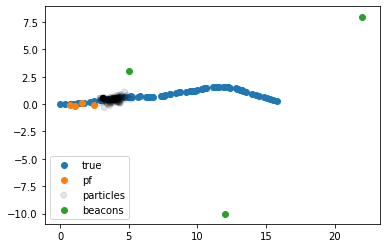

In [61]:
print("Trained network")
# print(np.exp(particle_weights))
plot_trajectories(
    true=true_states,
    pf=pf_states,
    particles=(particle_states, particle_weights),
    beacons=observer.locations
)

In [40]:
print("Trained network")
plot_trajectories(
    true=true_states,
    pf=pf_states,
    particles=(particle_states[0].cpu().numpy(), particle_weights[0].cpu().numpy()),
    beacons=observer.locations
)

Trained network


AttributeError: 'numpy.ndarray' object has no attribute 'cpu'